Собянин Максим Андреевич, РИ-411003

In [1]:
ls

machine_temperature_system_failure.csv  sample_data/


##**Данные**

Выберите для анализа один из двух временных рядов.
Выберем второй временной ряд.

In [2]:
%%capture
!pip install etna[all] -U

Подключение библиотек.

In [3]:
import torch
import random

import pandas as pd
import numpy as np

from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform, LagTransform, LinearTrendTransform, StandardScalerTransform
from etna.metrics import SMAPE, MAPE, MAE
from etna.analysis import plot_backtest
from etna.models import SeasonalMovingAverageModel
from etna.models.nn import DeepARModel, RNNModel
from etna.models.nn.utils import PytorchForecastingDatasetBuilder

from pytorch_forecasting.data import GroupNormalizer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA



In [4]:
data = pd.read_csv('machine_temperature_system_failure.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

###Визуализируйте ряд и на основе его внешнего вида сделайте предположения о его компонентах (тренд, сезонность) и стационарности

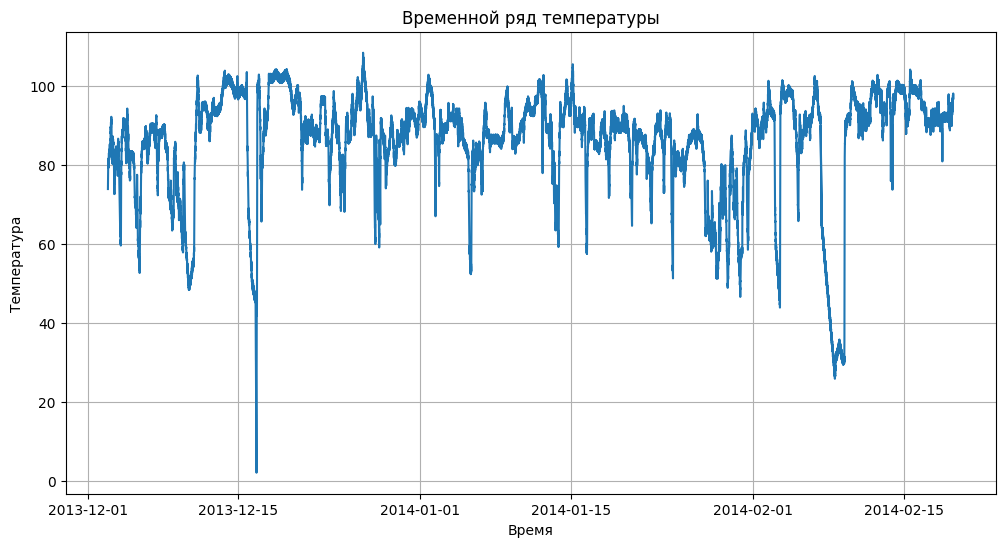

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(data['value'])
plt.title('Временной ряд температуры')
plt.xlabel('Время')
plt.ylabel('Температура')
plt.grid()
plt.show()

По полученной визуализации не получится сделать выводы о трендах, сезонности и стационарности.

###Сделайте train/test split

In [6]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

print(f'Train size: {len(train)}, Test size: {len(test)}')

Train size: 18156, Test size: 4539


###Выберите релевантную, на ваш взгляд, метрику для последующих замеров качества

Выберем метрику для последующих замеров: MAE (Mean Absolute Error). Она показывает среднее отклонение прогноза от фактических значений.

##**Прогнозирование**

###Постройте бейзлайн в виде наивного прогноза или скользящего среднего

Наивный прогноз выполним следующим образом: для каждого временного шага используем значение предыдущего временного шага. Модель простая, однако может выступать в качестве хорошего бейзлайна.

In [8]:
# Наивный прогноз
train['naive_forecast'] = train['value'].shift(1)

# Удаление NaN значений
train = train.dropna()

###Визуализируйте результаты работы модели, произведите замеры качества с выбранной метрикой

Визуализируем результаты наивного прогноза и произведем замеры качества.

Mean Absolute Error (MAE): 12.00617108008155


Text(0.5, 1.0, 'Naive Forecast vs Actual Values')

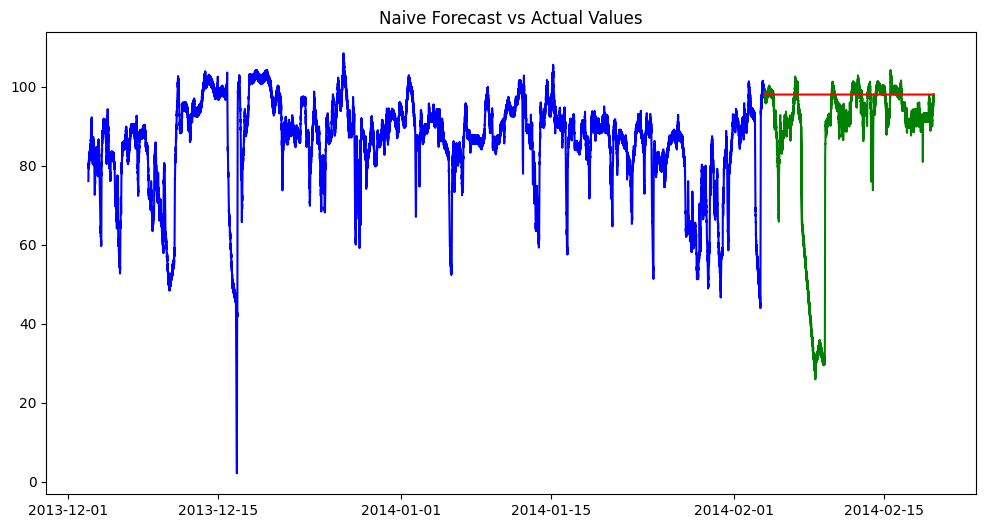

In [10]:
# Прогноз на тестовой
test['naive_forecast'] = train['value'].iloc[-1]
test['naive_forecast'] = test['naive_forecast'].shift(1)
test = test.dropna()

# MAE
baseline_mae = mean_absolute_error(test['value'], test['naive_forecast'])
print(f'Mean Absolute Error (MAE): {baseline_mae}')

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train', color='blue')
plt.plot(test.index, test['value'], label='Test', color='green')
plt.plot(test.index, test['naive_forecast'], label='Naive Forecast', color='red')
plt.title('Naive Forecast vs Actual Values')

##Статистическая модель

###Проведите тест Дики-Фуллера и интерпретируйте результаты

Тест Дики-Фуллера (ADF) позволяет проверить стационарность временного ряда. Если p-значение меньше 0.05, мы отвергаем гипотезу о наличии единичного корня, что указывает на стационарность ряда.

In [11]:
result = adfuller(data['value'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')

ADF Statistic: -7.3690895644913414
p-value: 9.071345315518266e-11
Critical Values:
1%: -3.4306384378792365
5%: -2.861667480233377
10%: -2.566837854101014


###Постройте графики ACF/PACF и проанализируйте их, сделайте предположения о наличии/отсутствии сезонности

Графики автокорреляции (ACF) и частичной автокорреляции (PACF) помогут нам проанализировать наличие сезонности и определить порядок авторегрессионной модели.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


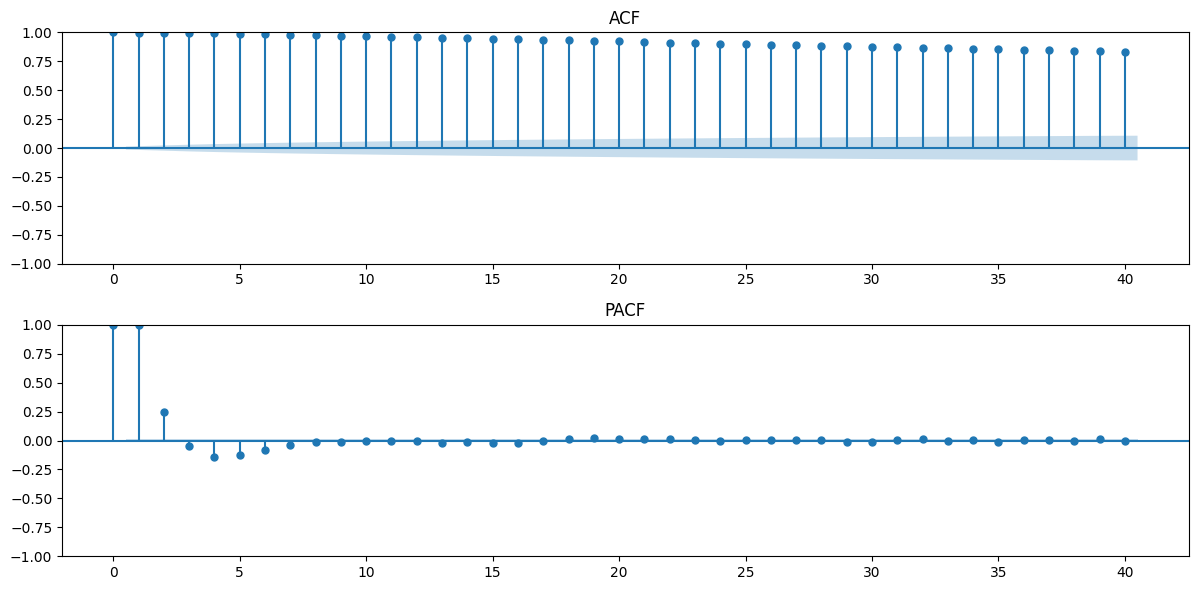

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(data['value'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF')

plt.subplot(212)
plot_pacf(data['value'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()

###Проведите необходимые на ваш взгляд преобразования для придания ряду стационарности (дифференцирование / сезонное дифференцирование)

Для не стацианарного ряда можно использовать дифференцирование. Для сезонного можно использовать сезонное дифференцирование.

In [14]:
# Удаление дубликатов
data = data[~data.index.duplicated(keep='first')]
print(data.index.duplicated().sum())

# Дифференцирование
data['value_diff'] = data['value'].diff().dropna()

# Сезонное дифференцирование
data['value_seasonal_diff'] = data['value'].diff(12).dropna()

0


###Проверьте стационарность полученного ряда с тестом Дики-Фуллера и визуализацией ACF/PACF

После преобразования проверим стационарность и построим ACF/PACF для дифференцированного ряда.

ADF Statistic (Differenced): -30.307886110051996
p-value (Differenced): 0.0


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


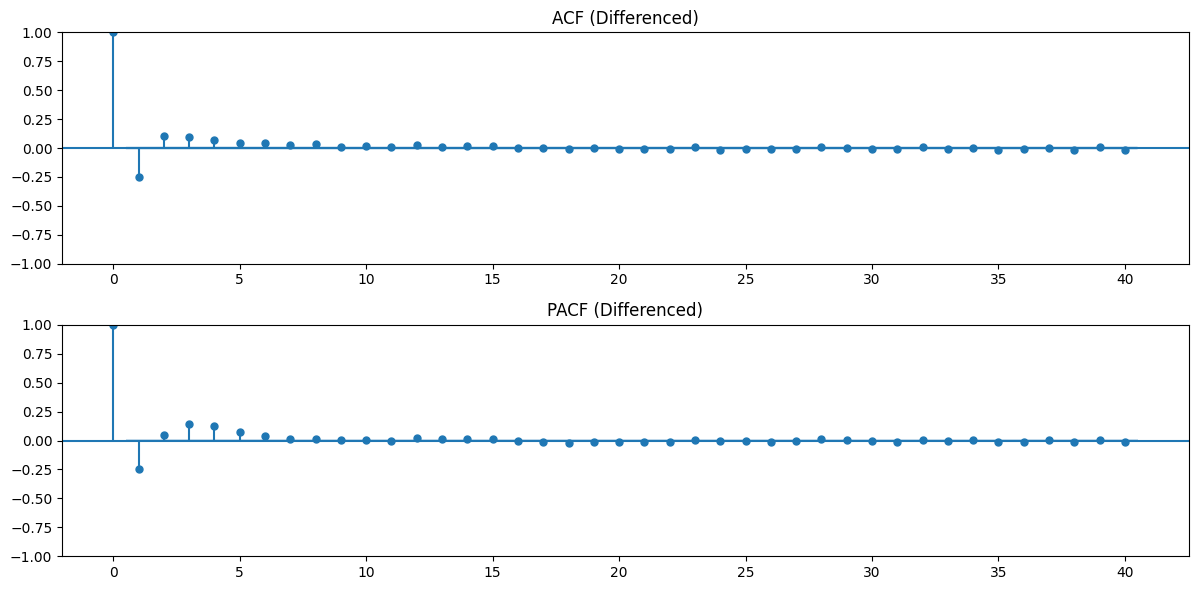

In [15]:
result_diff = adfuller(data['value_diff'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])

plt.figure(figsize=(12, 6))

plt.subplot(211)
plot_acf(data['value_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF (Differenced)')

plt.subplot(212)
plot_pacf(data['value_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF (Differenced)')

plt.tight_layout()
plt.show()

###Обучите модель ARIMA или SARIMA для прогнозирования значений ряда, подобрав оптимальные параметры

Теперь мы можем обучить модель ARIMA или SARIMA, используя параметры, полученные из графиков ACF и PACF.

Установим и используем auto_arima для автоматического определения параметров p,d и q

In [16]:
   !pip install pmdarima
   from pmdarima import auto_arima
   train_size = int(len(data) * 0.8)
   train, test = data[:train_size], data[train_size:]
   model = auto_arima(train['value'], seasonal=False, stepwise=True)
   print(model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18146
Model:               SARIMAX(1, 1, 2)   Log Likelihood              -26277.841
Date:                Mon, 23 Dec 2024   AIC                          52563.683
Time:                        11:01:27   BIC                          52594.907
Sample:                    12-02-2013   HQIC                         52573.947
                         - 02-03-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7758      0.012     64.588      0.000       0.752       0.799
ma.L1         -1.0380      0.011    -95.429      0.000      -1.059      -1.017
ma.L2          0.3292      0.004     86.055      0.0

На основе результатов, полученных с помощью auto_arima, мы можем заменить параметры p, d и q коде следующим образом:

•  p = 1 (ar.L1) - порядок авторегрессии

•  d = 1 (SARIMAX(1, 1, 2)) - порядок интегрирования

•  q = 2 (ma.L1 и ma.L2.) - порядок скользящего среднего

In [18]:
model = ARIMA(train['value'], order=(1, 1, 2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                18146
Model:                 ARIMA(1, 1, 2)   Log Likelihood              -26277.841
Date:                Mon, 23 Dec 2024   AIC                          52563.683
Time:                        11:04:14   BIC                          52594.907
Sample:                    12-02-2013   HQIC                         52573.947
                         - 02-03-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7758      0.012     64.588      0.000       0.752       0.799
ma.L1         -1.0380      0.011    -95.429      0.000      -1.059      -1.017
ma.L2          0.3292      0.004     86.055      0.0

###Визуализируйте результаты работы модели, произведите замеры качества модели ARIMA (или SARIMA)

Наконец, визуализируем результаты прогноза и произведем замеры качества модели.

<ipython-input-19-3687f2de2f02>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecast'] = forecast


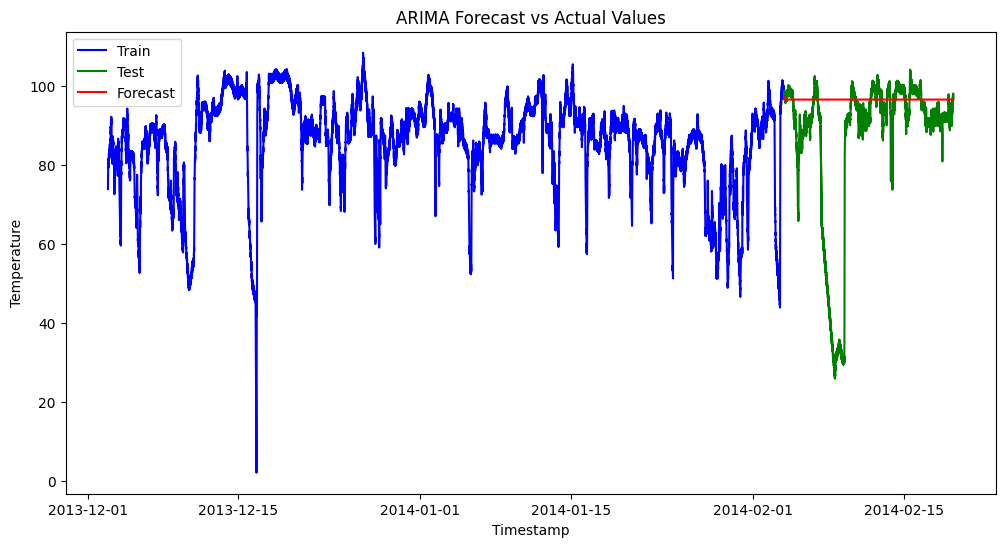

Mean Absolute Error (MAE): 11.366920512054124


In [19]:
forecast = model_fit.forecast(steps=len(test))
test['forecast'] = forecast

plt.figure(figsize=(12, 6))
plt.plot(train.index, train['value'], label='Train', color='blue')
plt.plot(test.index, test['value'], label='Test', color='green')
plt.plot(test.index, test['forecast'], label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual Values')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()

test = test.dropna(subset=['value', 'forecast'])
arima_mae = mean_absolute_error(test['value'], test['forecast'])
print(f'Mean Absolute Error (MAE): {arima_mae}')

##Классическая модель

###Используйте Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc)

Создадим новые признаки на основе временных меток и скользящих статистик, затем можем извлечь признаки:

*   Час, день, месяц, год
*   День недели
*   Скользящие средние и стандартные отклонения
*   Лаги (предыдущие значения)

In [20]:
# Новые признаки
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Скользящие средние
data['rolling_mean_3'] = data['value'].rolling(window=3).mean()
data['rolling_std_3'] = data['value'].rolling(window=3).std()

# Лаги
data['lag_1'] = data['value'].shift(1)
data['lag_2'] = data['value'].shift(2)

# Отбросим NaN значения
data.dropna(inplace=True)

# Разделение на обучающую и тестовую выборки
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

###На полученном наборе данных обучите случайный лес или градиентный бустинг

Теперь мы можем использовать случайный лес или градиентный бустинг. Используем случайный лес из библиотеки sklearn, так получается более простая и быстрая модель.

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Определение признаков и целевой переменной
X_train = train.drop('value', axis=1)
y_train = train['value']
X_test = test.drop('value', axis=1)
y_test = test['value']

# Обучение модели
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка качества модели
forest_mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {forest_mae}')

Mean Absolute Error: 0.34105585133935135


###Визуализируйте результаты работы модели, произведите замеры качества модели

Теперь визуализируем результаты предсказаний модели по сравнению с реальными значениями.

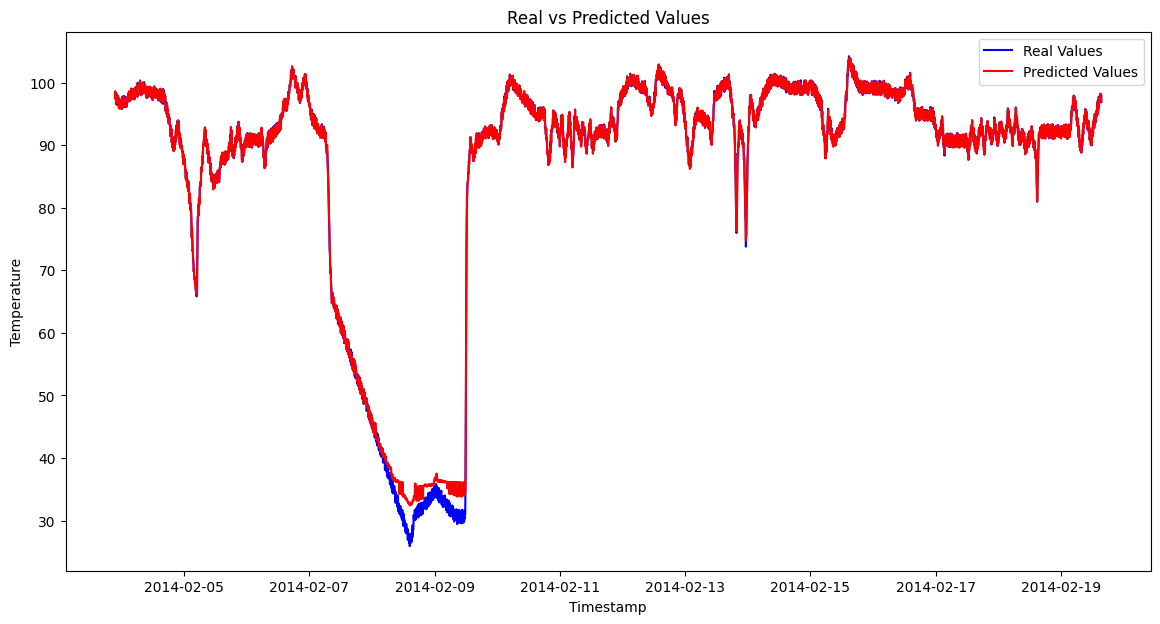

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, label='Real Values', color='blue')
plt.plot(test.index, y_pred, label='Predicted Values', color='red')
plt.title('Real vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Temperature')
plt.legend()
plt.show()

##Нейросетевая модель

###Обучить на выбранном временном ряду модель RNNModel из библиотеки ETNA

In [23]:
df = pd.read_csv('machine_temperature_system_failure.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.rename(columns={'timestamp': 'timestamp', 'value': 'target'})
df['segment'] = 'main'
df = df.drop_duplicates(subset='timestamp', keep='first')
df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq='5T')
ts.head()

segment,main
feature,target
timestamp,
2013-12-02 21:15:00,73.967322
2013-12-02 21:20:00,74.935882
2013-12-02 21:25:00,76.124162
2013-12-02 21:30:00,78.140707
2013-12-02 21:35:00,79.329836


In [24]:
HORIZON = 7
model_rnn = RNNModel(
    decoder_length=HORIZON,
    encoder_length=2 * HORIZON,
    input_size=11,
    trainer_params=dict(max_epochs=5),
    lr=1e-3,
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)

pipeline_rnn = Pipeline(
    model=model_rnn,
    horizon=HORIZON,
    transforms=[StandardScalerTransform(in_column="target"), transform_lag],
)
metrics = [SMAPE(), MAPE(), MAE()]
metrics_rnn, forecast_rnn, fold_info_rnn = pipeline_rnn.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type    | Params
---------------------------------------
0 | loss       | MSELoss | 0     
1 | rnn        | 

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.7min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  7.1min
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:108: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 10.6min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed: 10.6min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.0s


Усредненное значение MAE для LSTM: 0.756


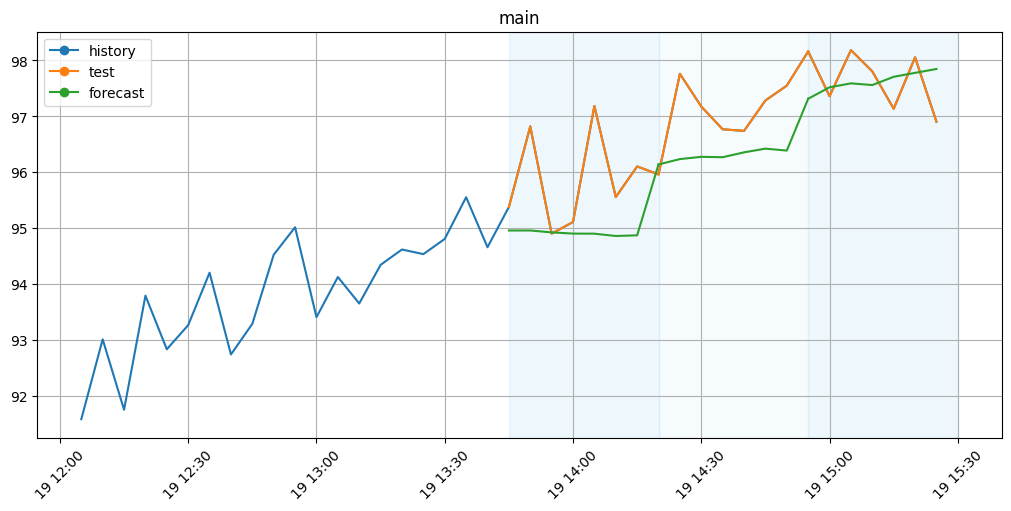

In [26]:
rnn_mae = metrics_rnn["MAE"].mean()
print(f"Усредненное значение MAE для LSTM: {rnn_mae:.3f}")
plot_backtest(forecast_rnn, ts, history_len=20)

### Обучение модели DeepAR с Feature Engineering

In [27]:
transform_date = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=False,
    out_column='dateflag'
)

num_lags = 10
transform_lag = LagTransform(
    in_column='target',
    lags=[HORIZON + i for i in range(num_lags)],
    out_column='target_lag'
)
lag_columns = [f'target_lag_{HORIZON+i}' for i in range(num_lags)]

dataset_builder_deepar = PytorchForecastingDatasetBuilder(
    max_encoder_length=HORIZON,
    max_prediction_length=HORIZON,
    time_varying_known_reals=['time_idx'] + lag_columns,
    time_varying_unknown_reals=['target'],
    time_varying_known_categoricals=['dateflag_day_number_in_week'],
    target_normalizer=GroupNormalizer(groups=['segment']),
)

model_deepar = DeepARModel(
    dataset_builder=dataset_builder_deepar,
    trainer_params=dict(max_epochs=5, gpus=0, gradient_clip_val=0.1),
    lr=0.01,
    train_batch_size=64
)

pipeline_deepar = Pipeline(
    model=model_deepar,
    horizon=HORIZON,
    transforms=[transform_lag, transform_date]
)

metrics_deepar, forecast_deepar, _ = pipeline_deepar.backtest(ts, metrics=metrics, n_folds=3, n_jobs=1)

<ipython-input-27-380ef5cb42ca>:24: DeprecationWarning: Call to deprecated class DeepARModel. (DeepARModel is deprecated. Use DeepARNativeModel instead.) -- Deprecated since version 3.0.
  model_deepar = DeepARModel(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved d

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/data/timeseries.py:1657: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  target_scale = torch.tensor([batch[0]["target_scale"] for batch in batches], dtype=torch.float)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:83: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorc

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  5.4min
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:445: RuntimeWarning: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.1min
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  8.1min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:   14.4s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.6s


Усредненное значение MAE для DeepAR с FE: 0.679


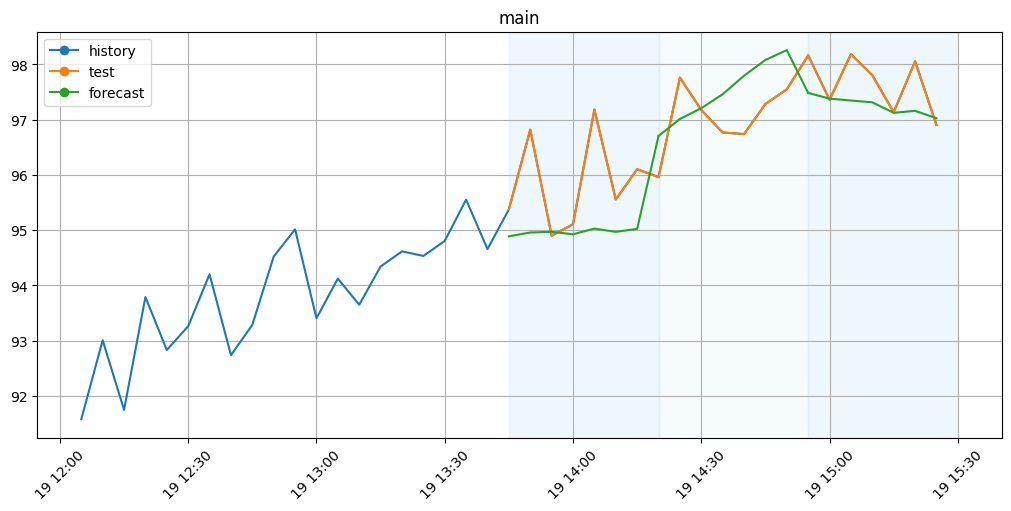

In [28]:
deepar_mae = metrics_deepar['MAE'].mean()
print(f"Усредненное значение MAE для DeepAR с FE: {deepar_mae:.3f}")
plot_backtest(forecast_deepar, ts, history_len=20)

In [29]:
# Сбор метрик
metrics = pd.DataFrame({
    'Model': ['Baseline', 'ARIMA', 'Random Forest', 'RNN', 'DeepAR'],
    'MAE': [baseline_mae, arima_mae, forest_mae, rnn_mae, deepar_mae]
})

print(metrics)

           Model        MAE
0       Baseline  12.006171
1          ARIMA  11.366921
2  Random Forest   0.341056
3            RNN   0.756232
4         DeepAR   0.678970


##Выводы
1. Baseline:
   - Модель Baseline MAE - 12.006171.
   Значение довольно высокое, это говорит о том, что модель вполне может давать значения отличные от реальных. Можно предположить, что модель недостаточно хорошо адаптирована.

2. ARIMA:
   - У модели ARIMA MAE - 11.366921.
   Значение довольно высокое, однако ниже, чем у базовой модели.

3. Random Forest:
   - Random Forest MAE – 0.341056.
   Это говорит о высокой точности модели, прогнозы довольно точные.

4. RNN:
   - Рекуррентная нейронная сеть (RNN) MAE - 0.756232.
   Показатель выше чем у Random Forest, однако является достаточно низким, чтобы говорит о том, что модель точна.

5. DeepAR:
   - DeepAR MAE - 0.678970.
   Результат уступает Random Forest и RNN, однако он также достаточно низкий чтобы говорит о приемлимой точности модели.


### Общие выводы:
- Random Forest дает наилучшие результаты среди всех представленных моделей, демонстрируя наименьшую ошибку MAE.
- RNN и DeepAR показывают достаточно хорошие результаты, но уступают Random Forest.
- Модели Baseline и ARIMA имеют большую ошибку.
